describing dependencies

In [7]:
cd ~/Documents/WQU/WQU_650-ml_for_finance/intro_to_deep_learning/

/home/neelkanth/Documents/WQU/WQU_650-ml_for_finance/intro_to_deep_learning


#### Importing Libraries

In [8]:
# Importing standard libraries
import sys
import time
import re
import os
import json
from pathlib import PurePath, Path

# Importing scientific libraries
import numpy as np
import pandas as pd
os.environ['THEANO_FLAGS'] = 'device=cpu, floatX=float32'
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt
import ta

# importing visual libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.weight'] = 'medium'

blue, grean, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# Import util libs
import pyarrow as palind
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

# user defined libraries
from src.utils.utils import *
from src.features.bars import get_imbalance
import src.features.bars as brs
import src.features.snippets as snp

RANDOM_STATE = 777

In [9]:
infp = PurePath('./data/IVE_tickbidask.txt')

#### loading and cleaning data

In [10]:
"""Reading and Cleaning data"""

def read_kibot_ticks(fp):
    cols = list(map(str.lower, ['Date', 'Time', 'Price', 'Bid', 'Ask', 'Size']))
    df = (pd.read_csv(fp, header=None)
    .rename(columns=dict(zip(range(len(cols)), cols)))
    .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'], format='%m/%d/%Y%H:%M:%S')))
    .assign(v = lambda df: df['size']) # volume
    .assign(dv= lambda df: df['price']*df['size']) # dollar volume
    .drop(['date', 'time'], axis=1)
    .set_index('dates')
    .drop_duplicates())
    return df

In [11]:
# Creating a tick dataframe
df = read_kibot_ticks(infp)

In [12]:
# Printing the output fataframe
outfp = PurePath('./data/IVE_tickbidask.parq')
df.to_parquet(outfp)

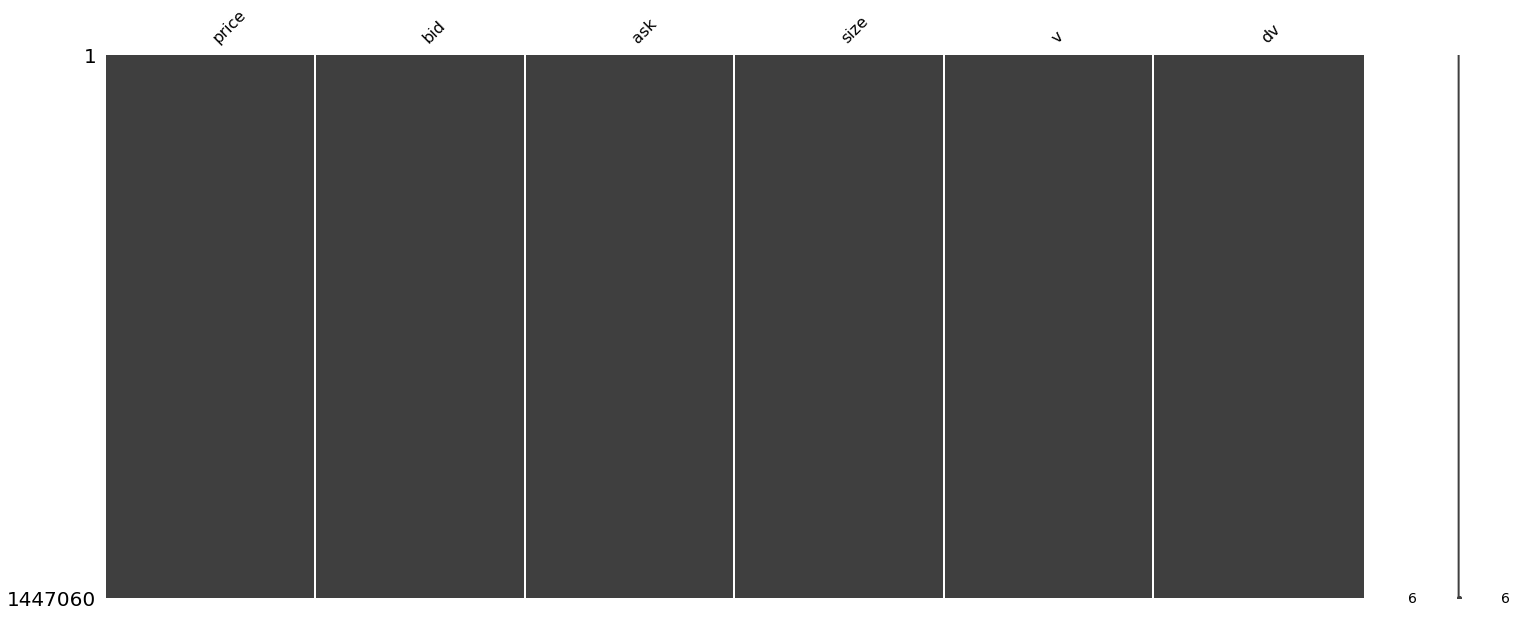

In [13]:
# missing numbers
msno.matrix(df)

In [14]:
"""Eliminating outliers from the dataset"""
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y-median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    
    modified_z_score = 0.6745 * diff/ med_abs_deviation
    return modified_z_score > thresh

In [15]:
# defining variable mad
mad = mad_outlier(df.price.values.reshape(-1,1))

# removing outliers
df = df.loc[~mad]

In [16]:
"""Exporting the processed data to file"""
outfp = PurePath('./data/clean_IVE_fut_prices.parq')
df.to_parquet(outfp)

In [17]:
"""Creating Dollar Bars"""
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    
    # args
        df: pd.DataFrame()
        dv_column: name of dollar volume bar
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

In [18]:
# loading data - if not already loaded
df = pd.read_parquet('./data/clean_IVE_fut_prices.parq')
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-31 16:10:00  109.65  108.01  116.99      0      0        0.00
2018-10-31 16:17:27  109.63  109.63  116.99    190    190    20829.70
2018-10-31 18:25:11  109.65  108.11  109.90  14993  14993  1643982.45
2018-10-31 18:30:00  109.65  108.11  109.90      0      0        0.00
2018-10-31 20:00:00  109.65  109.14  109.90      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447049 entries, 2009-09-28 09:30:00 to 2018-10-31 20:00:00
Data columns (total 6 columns):
price    1447049 non-null float64
bid      1447049 non-null float64
ask      1447049 non-null float64
size     1447049 non-null int6

In [19]:
# executing the function:
dollar_M = 1_000_000  # arbitrary
print(f"dollar threshold: {dollar_M:,}")
dv_bar_df = dollar_bar_df(df,'dv', dollar_M)
cprint(dv_bar_df)

 19%|█▊        | 270409/1447049 [00:00<00:01, 1080683.60it/s]

dollar threshold: 1,000,000


100%|██████████| 1447049/1447049 [00:00<00:00, 1896402.27it/s]


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-31 15:56:55  109.73  109.74  109.74    800    800    87784.00
2018-10-31 15:56:55  109.73  109.73  109.74   2700   2700   296271.00
2018-10-31 15:59:33  109.60  109.60  109.62    700    700    76720.00
2018-10-31 16:00:00  109.65  109.62  109.63  68570  68570  7518700.50
2018-10-31 18:25:11  109.65  108.11  109.90  14993  14993  1643982.45
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52200 entries, 2009-09-28 09:46:35 to 2018-10-31 18:25:11
Data columns (total 6 columns):
price    52200 non-null float64
bid      52200 non-null float64
ask      52200 non-null float64
size     52200 non-null int64
v       

In [20]:
# Resampling
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf= sub[price_col].loc[date]
    return xdf, xtdf

xDate = '2009-10-01' #'2017-10-4'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)

In [21]:
"""Exporting the Dollar Bar"""
dv_bar_df.to_csv('./data/dataset.csv', sep=',', header=True)

#### generate labell and features

In [22]:
dataset = pd.read_csv('./data/dataset.csv', index_col=0)
dataset['dv'] = dataset['dv'].astype(np.int64)
dataset.index = pd.to_datetime(dataset.index)

In [23]:
# Creating ohlc data
price = dataset['price'].resample('10Min').ohlc().fillna(method='ffill').dropna(how='all')

df = price.merge(dataset[['v','dv']], how='outer', left_index=True, right_index=True).fillna(method='ffill').dropna(how='all')
df['v'][0], df['dv'][0] = 0, 0

cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                       open    high     low   close        v         dv
dates                                                                  
2018-10-31 17:50:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:00:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:10:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:20:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:25:11  109.65  109.65  109.65  109.65  14993.0  1643982.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528918 entries, 2009-09-28 09:40:00 to 2018-10-31 18:25:11
Data columns (total 6 columns):
open     528918 non-null float64
high     528918 non-null float64
low      528918 non-null float64
close    528918 non-

#### Generating Labels:

In [24]:
'''For details, ref: https://bit.ly/2CZp7OB'''
y_vol = np.sqrt(252) * pd.DataFrame.rolling(np.log(df['close']/df['close'].shift(1)), window=14).std().fillna(value=0)

In [25]:
# Awsome Oscillator
ao = ta.momentum.ao(high=df['high'], low=df['low'], fillna=True)

 # Relative Strength Index
rsi = ta.momentum.rsi(close=df['close'], fillna=True)

# True Strength Index
tsi = ta.momentum.tsi(close=df['close'], fillna=True) 

# MACD
macd = ta.trend.macd(close=df['close'], fillna=True) 

# William's %R
r_pct = ta.momentum.wr(high=df['high'], low=df['low'], close=df['close'], fillna=True) 

# East of Movement
EoM = ta.volume.ease_of_movement(high=df['high'], low=df['low'], close=df['close'], volume=df['v'],fillna=True) 

# Chaikin Money Flow
cmf = ta.volume.chaikin_money_flow(high=df['high'], low=df['low'], close=df['close'], volume=df['v'], fillna=True) 

# Force Index
force_index = ta.volume.force_index(close=df['close'], volume=df['v'], fillna=True)

In [26]:
# Combining eight features in single df
features = pd.concat((ao, rsi, tsi, macd, r_pct, EoM, cmf, force_index), axis=1)
cols = ['ao', 'rsi', 'tsi', 'macd', 'r_pct', 'EoM', 'cmf', 'force_index']
features.columns = cols

#### Standardizing the dataset

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
standard = sc.fit_transform(features)

#### Principal Component Analysis

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4, svd_solver='full')
processed = pca.fit_transform(standard)

In [29]:
pca.explained_variance_ratio_

array([0.38908885, 0.17614144, 0.13844514, 0.12495265])

In [30]:
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7
0,-0.475328,-0.419216,-0.424259,-0.486740,-0.369571,-0.120375,-0.173867,0.010330
1,-0.285024,0.115428,-0.077000,-0.304607,0.510330,-0.309534,0.671173,0.001484
2,-0.151259,0.408471,0.431898,-0.165594,-0.169257,-0.670467,-0.340497,-0.046933
3,-0.004825,-0.018148,-0.022357,-0.001983,0.009925,0.038448,0.010000,-0.998733
